In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *

#### Import the 2b fluxes

In [2]:
df_2b = pd.read_csv('data/coll_2b.csv', parse_dates = [0], index_col = 0)

In [3]:
df_2b = df_2b[0:120]

In [4]:
df_2b.tail()

,c_open,c_close
date,,
2014-07-24 03:03:00,13.851,16.8360
2014-07-24 04:07:00,19.341,20.4410
2014-07-24 05:10:00,20.896,15.7890
2014-07-24 06:14:00,19.704,6.6863
2014-07-24 07:18:00,33.954,16.4870


#### Find flux

In [5]:
flux = []
for idx, row in df_2b.iterrows():
    flux.append(-(0.0015/0.1574)*(row['c_open']-row['c_close'])*584.6529/(298))
df_2b['flux'] = flux

In [6]:
day_hour = df_2b.reset_index().apply(lambda x: str(x.date.day) + '-'+  str(x.date.hour), axis=1)

In [7]:
df_2b['day_hour'] = list(day_hour)

In [8]:
df_2b.head()

,c_open,c_close,flux,day_hour
date,,,,
2014-07-18 16:39:00,41.183,42.369,0.022174,18-16
2014-07-18 17:42:00,49.626,37.207,-0.232196,18-17
2014-07-18 18:46:00,26.638,46.415,0.369768,18-18
2014-07-18 19:49:00,34.020,18.391,-0.292213,18-19
2014-07-18 20:53:00,30.356,30.103,-0.004730,18-20


#### Import the MOx fluxes

In [15]:
df_mox = pd.read_csv('data/cham4_coll_fluxes.csv', index_col = 0, parse_dates = 0)

In [16]:
df_mox.head()

,close_conc,flux,open_conc
2014-07-21 17:00:00,40.253278,-0.435991,63.572230
2014-07-21 18:00:00,37.704454,-0.319284,54.781319
2014-07-21 19:00:00,35.490288,-0.350188,54.220056
2014-07-21 20:00:00,30.995508,-0.278388,45.885054
2014-07-21 21:00:00,24.417987,0.006021,24.095942


In [17]:
df_mox.dropna(inplace=True)

In [18]:
mox_day_hour = df_mox.reset_index().apply(lambda x: str(x['index'].day) + '-'+  str(x['index'].hour), axis=1)

In [19]:
df_mox['day_hour'] = list(mox_day_hour)

In [20]:
df_mox = df_mox.rename(columns={'close_conc':'mox_cl_conc', 'flux':'mox_flux', 'open_conc':'mox_open_conc'})

In [21]:
df_mox['hour'] = df_mox.index.hour

In [22]:
df_mox = df_mox.reset_index()

In [23]:
df = pd.merge(df_mox, df_2b, on='day_hour')

In [24]:
df = df.set_index('index')

In [25]:
df.mox_flux = -df.mox_flux
df.flux = -df.flux

In [26]:
df.head()

,mox_cl_conc,mox_flux,mox_open_conc,day_hour,hour,c_open,c_close,flux
index,,,,,,,,
2014-07-21 17:00:00,40.253278,0.435991,63.572230,21-17,17,70.817,43.3320,0.513883
2014-07-21 18:00:00,37.704454,0.319284,54.781319,21-18,18,40.036,40.1730,-0.002561
2014-07-21 19:00:00,35.490288,0.350188,54.220056,21-19,19,28.114,42.8890,-0.276246
2014-07-21 20:00:00,30.995508,0.278388,45.885054,21-20,20,37.407,6.9174,0.570059
2014-07-21 21:00:00,24.417987,-0.006021,24.095942,21-21,21,24.421,13.2470,0.208919


In [27]:
def plot_2b_vs_mox(df, title):
    plt.figure(facecolor='w', figsize = (8,8))
    a, b, axes, label_size = plot_params()
    plt.plot(df.flux, df.mox_flux, linestyle = '', marker = 'o', alpha = .9)
    plt.xlabel('2B Ozone Flux', size = label_size)
    plt.ylabel('MOx Ozone Flux', size = label_size)
    plt.title(title, size=22)
    plt.plot([df.flux.max(), df.flux.min()], [df.flux.max(),df.flux.min()])

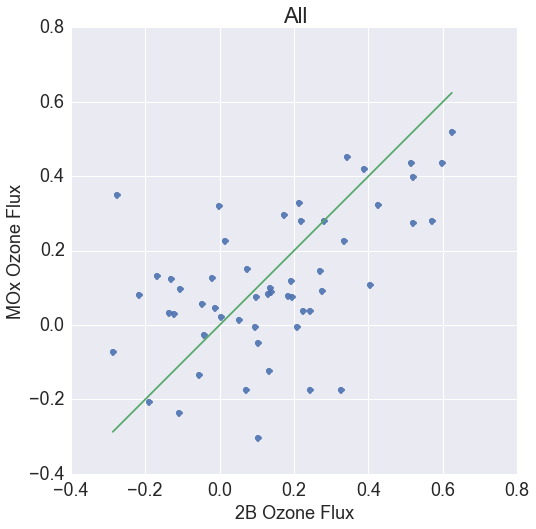

In [28]:
plot_2b_vs_mox(df, 'All')
plt.savefig("all.png")

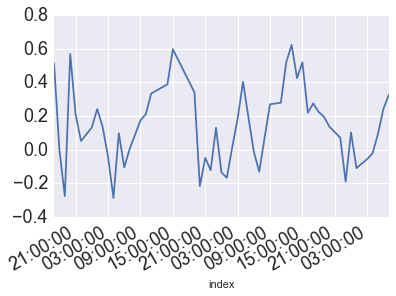

In [29]:
df.flux.plot()

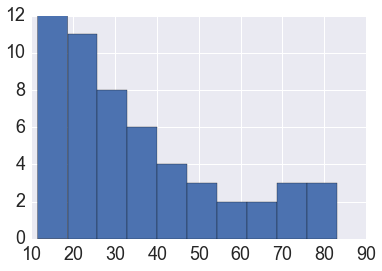

In [30]:
df.c_open.hist()

## Print Average Fluxes measured by both instruments

In [31]:
avg_flux_mox = np.mean(df.mox_flux)
avg_flux_2b = np.mean(df.flux)
print 'MOx flux:', round(avg_flux_mox, 2), "2B flux:", round(avg_flux_2b, 2)

MOx flux: 0.11 2B flux: 0.14


MOx flux: -0.02 2B flux: -0.01


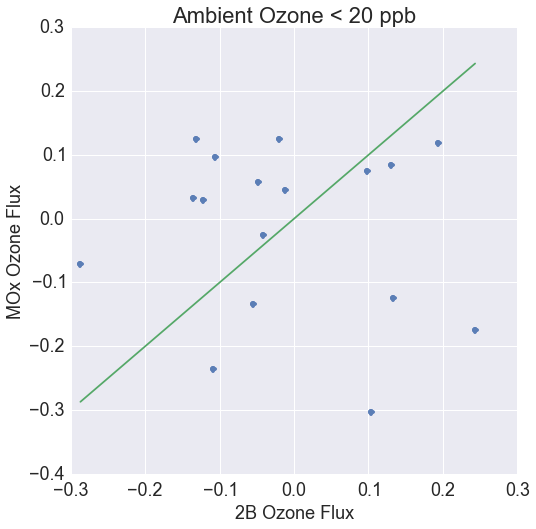

In [32]:
df_under_20 = df[df.c_open < 20]
plot_2b_vs_mox(df_under_20, 'Ambient Ozone < 20 ppb')
avg_flux_mox_under_20 = np.mean(df_under_20.mox_flux)
avg_flux_2b_under_20 = np.mean(df_under_20.flux)
print 'MOx flux:', round(avg_flux_mox_under_20, 2), "2B flux:", round(avg_flux_2b_under_20, 2)
plt.savefig("under_20.png")

MOx flux: 0.17 2B flux: 0.21


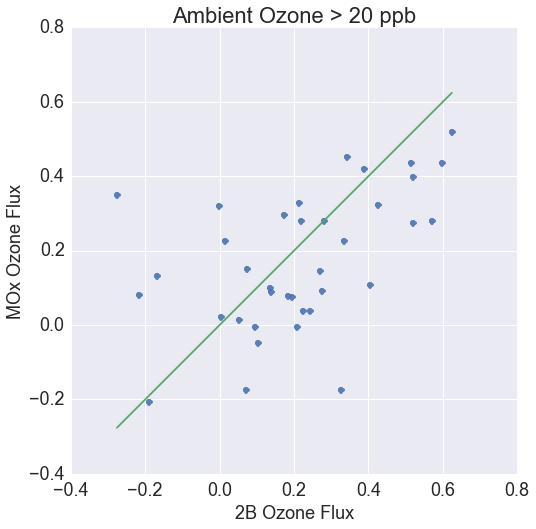

In [33]:
df_20_up = df[df.c_open > 20]
plot_2b_vs_mox(df_20_up, 'Ambient Ozone > 20 ppb')
avg_flux_mox_20_up = np.mean(df_20_up.mox_flux)
avg_flux_2b_20_up = np.mean(df_20_up.flux)
print 'MOx flux:', round(avg_flux_mox_20_up, 2), "2B flux:", round(avg_flux_2b_20_up, 2)

MOx flux: 0.07 2B flux: 0.1


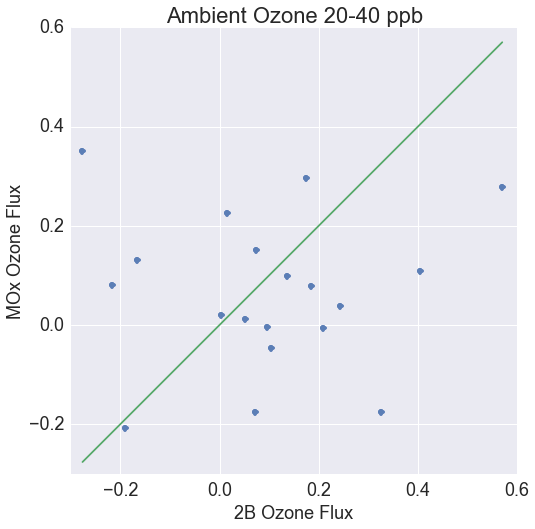

In [34]:
df_20_to_40 = df[(df.c_open < 40) & (df.c_open > 20)]
plot_2b_vs_mox(df_20_to_40, 'Ambient Ozone 20-40 ppb')
avg_flux_mox_20_to_40 = np.mean(df_20_to_40.mox_flux)
avg_flux_2b_20_to_40 = np.mean(df_20_to_40.flux)
print 'MOx flux:', round(avg_flux_mox_20_to_40, 2), "2B flux:", round(avg_flux_2b_20_to_40, 2)

MOx flux: 0.17 2B flux: 0.2


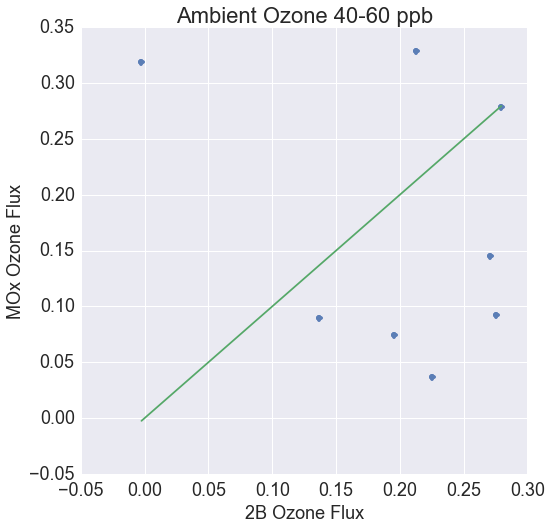

In [35]:
df_40_to_60 = df[(df.c_open < 60) & (df.c_open > 40)]
plot_2b_vs_mox(df_40_to_60, 'Ambient Ozone 40-60 ppb')
avg_flux_mox_40_to_60 = np.mean(df_40_to_60.mox_flux)
avg_flux_2b_40_to_60 = np.mean(df_40_to_60.flux)
print 'MOx flux:', round(avg_flux_mox_40_to_60, 2), "2B flux:", round(avg_flux_2b_40_to_60, 2)

MOx flux: 0.38 2B flux: 0.45


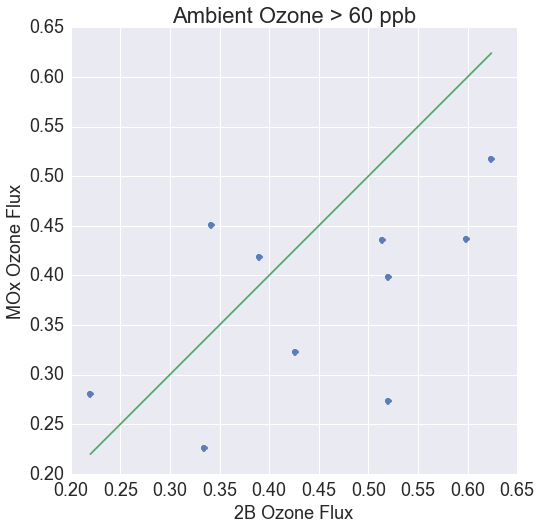

In [36]:
df_60_up = df[df.c_open > 60]
plot_2b_vs_mox(df_60_up, 'Ambient Ozone > 60 ppb')
avg_flux_mox_60_up = np.mean(df_60_up.mox_flux)
avg_flux_2b_60_up = np.mean(df_60_up.flux)
print 'MOx flux:', round(avg_flux_mox_60_up, 2), "2B flux:", round(avg_flux_2b_60_up, 2)

MOx flux: 0.11 2B flux: 0.14


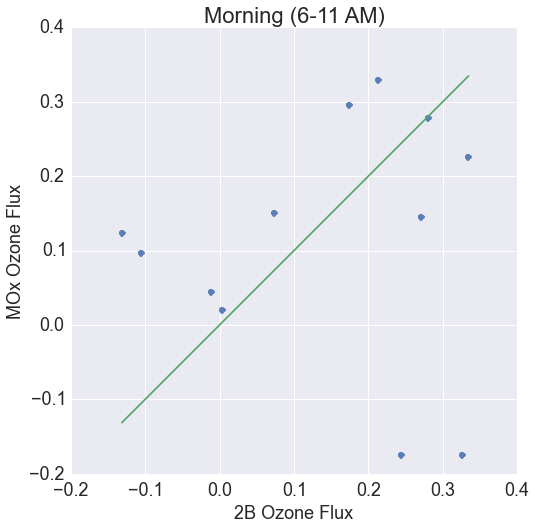

In [37]:
df_morning = df[(df.hour >= 6) & (df.hour < 12)]
plot_2b_vs_mox(df_morning, 'Morning (6-11 AM)')
avg_flux_mox_morning = np.mean(df_morning.mox_flux)
avg_flux_2b_morning = np.mean(df_morning.flux)
print 'MOx flux:', round(avg_flux_mox_morning, 2), "2B flux:", round(avg_flux_2b_morning, 2)

MOx flux: 0.32 2B flux: 0.39


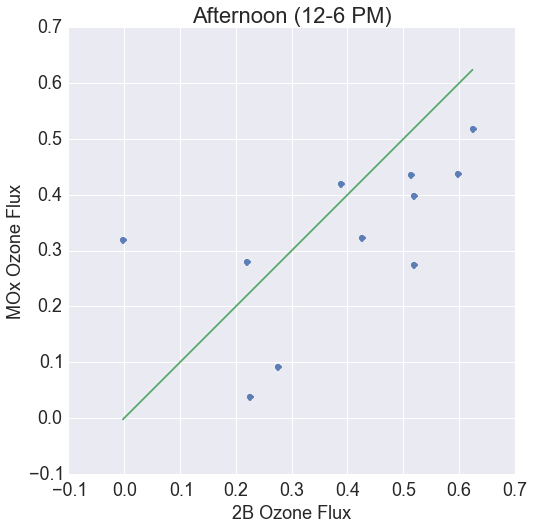

In [38]:
df_afternoon = df[(df.hour > 11) & (df.hour < 19)]
plot_2b_vs_mox(df_afternoon, 'Afternoon (12-6 PM)')
avg_flux_mox_afternoon = np.mean(df_afternoon.mox_flux)
avg_flux_2b_afternoon = np.mean(df_afternoon.flux)
print 'MOx flux:', round(avg_flux_mox_afternoon, 2), "2B flux:", round(avg_flux_2b_afternoon, 2)

MOx flux: 0.08 2B flux: 0.07


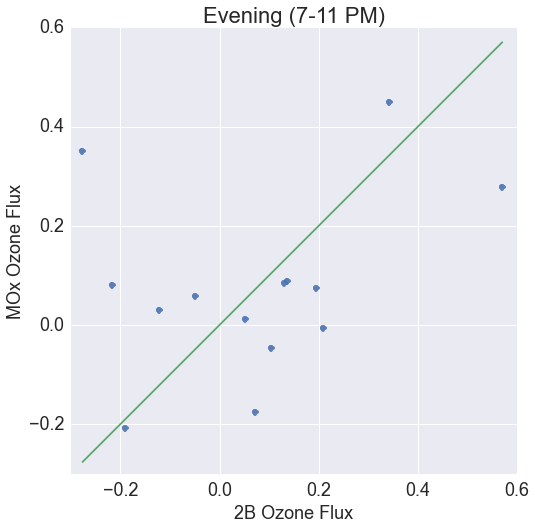

In [39]:
df_evening = df[(df.hour > 18) & (df.hour < 25)]
plot_2b_vs_mox(df_evening, 'Evening (7-11 PM)')
avg_flux_mox_evening = np.mean(df_evening.mox_flux)
avg_flux_2b_evening = np.mean(df_evening.flux)
print 'MOx flux:', round(avg_flux_mox_evening, 2), "2B flux:", round(avg_flux_2b_evening, 2)

MOx flux: 0.01 2B flux: 0.05


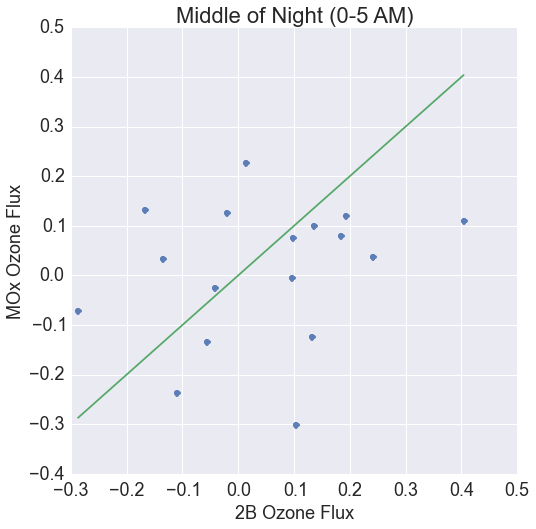

In [40]:
df_night = df[(df.hour >= 0) & (df.hour < 6)]
plot_2b_vs_mox(df_night, 'Middle of Night (0-5 AM)')
avg_flux_mox_night = np.mean(df_night.mox_flux)
avg_flux_2b_night = np.mean(df_night.flux)
print 'MOx flux:', round(avg_flux_mox_night, 2), "2B flux:", round(avg_flux_2b_night, 2)

In [41]:
def plot_mox_and_2b_vs_time(df, xlim):
    plt.figure(facecolor='w', figsize = (15,10))
    a, b, axes, label_size = plot_params()
    df.flux.plot(marker = 'o',linestyle = '--', label = '2B')
    if xlim != None:
        df.mox_flux.plot(marker = 'o',linestyle = '-', xlim = xlim, label = 'MOx')
    else:
        df.mox_flux.plot(marker = 'o',linestyle = '-', label = 'MOx')
#     axes.set_ylim([-10,90])
    plt.legend(fontsize = label_size, loc = "best")
    plt.ylabel('Ozone Flux', size = label_size)
    plt.xlabel('Date', size = label_size)

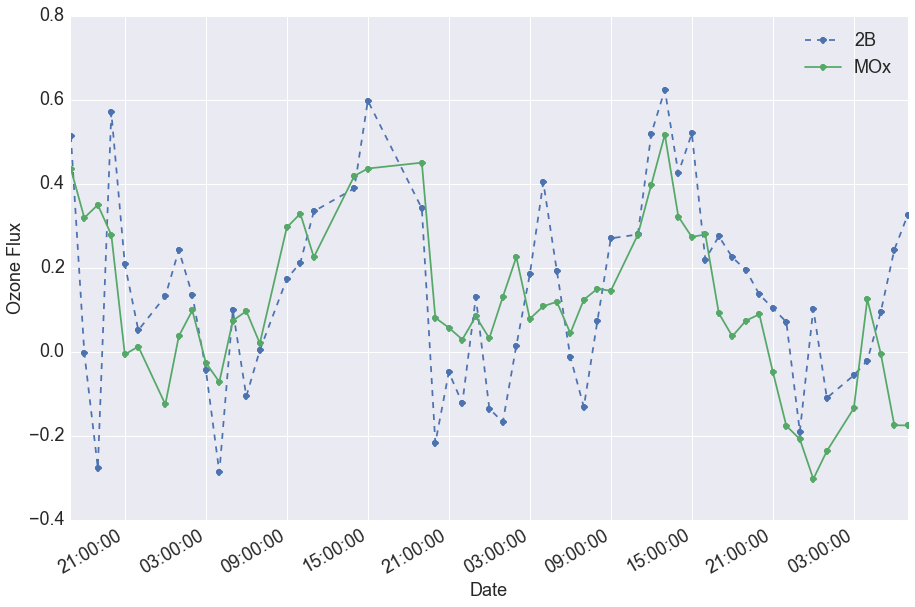

In [42]:
plot_mox_and_2b_vs_time(df, None)

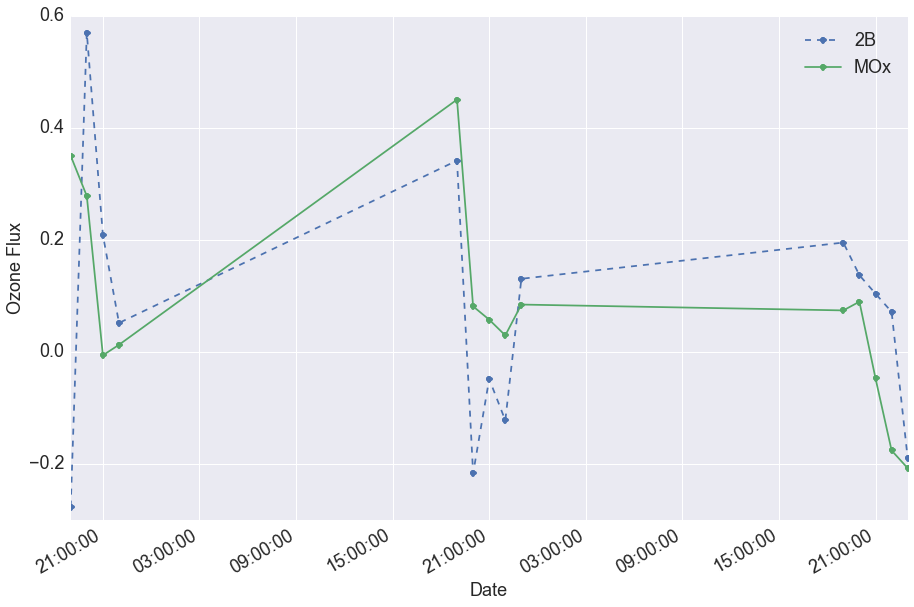

In [43]:
plot_mox_and_2b_vs_time(df_evening, None)